# Monte Carlo Simulation of Heston Model for discretely monitored fixed strike lookback call option using multiple variance reduction techniques (antithetic variate/control variate) and calibration

Scroll down to see comparisons for error reduction and computation time


In [30]:
# Import dependencies
import time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.linalg import cholesky
from datetime import datetime
import matplotlib.pyplot as plt

In [31]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)
div = 0.03     # continuous dividend yield

# Heston parameters
kappa = 5.0
vt0 = vol**2    # variance
theta = 0.2**2
sigma = 0.02
rho_scalar = -0.7
rho = np.array([[1,rho_scalar],
                [rho_scalar,1]])  # correlation between stoch proc


# fast steps
N = 52      # number of time intervals
M = 1000    # number of simulations

# Regular Heston

In [32]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)


# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:] )

    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]

# Compute Expectation and SE
CT = np.maximum(0, St_max - K)
C0_fast = np.exp(-r*T)*np.sum(CT)/M

SE_fast = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) ) /np.sqrt(M)

time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,2),np.round(SE_fast,2)))
print("Computation time is: ", time_comp_fast)

Call value is $16.69 with SE +/- 0.46
Computation time is:  0.0074


# With antithetic variates for underlying

In [44]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)


# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W1 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W2 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W1[j-1,:] )
    St2[j] = St2[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W2[j-1,:] )

    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]

# Compute Expectation and SE
CT = 0.5 * ( np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) )
C0_av = np.exp(-r*T)*np.sum(CT)/M

SE_av = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) ) /np.sqrt(M)

time_comp_av = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,2),np.round(SE_av,2)))
print("Calculation time: {0} sec".format(time_comp_av))

Call value is $15.16 with SE +/- 0.31
Calculation time: 0.0106 sec


## With antithetic variates for underlying and variance

In [34]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W1 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W2 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W3 = -rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W4 = -rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
St3 = np.full(shape=(N+1,M), fill_value=S0)
St4 = np.full(shape=(N+1,M), fill_value=S0)
vt1 = np.full(shape=(N+1,M), fill_value=vt0)
vt2 = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)
St3_max = np.full(shape=(M), fill_value=S0)
St4_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):

    # Simulate variance processes
    vt1[j] = vt1[j-1] + kappadt*(theta - vt1[j-1]) + sigmasdt*np.sqrt(vt1[j-1])*Z[j-1,:,0]
    vt2[j] = vt2[j-1] + kappadt*(theta - vt2[j-1]) - sigmasdt*np.sqrt(vt2[j-1])*Z[j-1,:,0]

    # Simulate log asset prices
    nudt1 = (r - div - 0.5*vt1[j])*dt
    nudt2 = (r - div - 0.5*vt2[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt1 + np.sqrt(vt1[j]*dt)*W1[j-1,:] )
    St2[j] = St2[j-1]*np.exp( nudt1 + np.sqrt(vt1[j]*dt)*W2[j-1,:] )
    St3[j] = St3[j-1]*np.exp( nudt2 + np.sqrt(vt2[j]*dt)*W3[j-1,:] )
    St4[j] = St4[j-1]*np.exp( nudt2 + np.sqrt(vt2[j]*dt)*W4[j-1,:] )

    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    mask3 = np.where(St3[j] > St3_max)
    mask4 = np.where(St4[j] > St4_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]
    St3_max[mask3] = St3[j][mask3]
    St4_max[mask4] = St4[j][mask4]

# Compute Expectation and SE
CT = 0.25 * ( np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) + np.maximum(0, St3_max - K) + np.maximum(0, St3_max - K))
C0_av_double = np.exp(-r*T)*np.sum(CT)/M

SE_av_double = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) ) /np.sqrt(M)

time_comp_av_double = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av_double,2),np.round(SE_av_double,2)))
print("Calculation time: {0} sec".format(time_comp_av_double))

Call value is $15.8 with SE +/- 0.22
Calculation time: 0.0152 sec


# Include control variates base on analytical solution continuous observations

Analytical solution continuous observations using finite differences

\begin{equation}
   C_{FSLC} = G + Se^{-\delta T} N(x + \sigma \sqrt{T}) - K e ^{-r T} N(x) - \frac{S}{B} \left(e^{-rT} \left(\frac{E}{S}\right)^B N(x+(1-B)\sigma \sqrt{T})-e^{-\delta T} N(x + \sigma \sqrt{T})\right),
\end{equation}
with
\begin{align}
B &= \frac{2(r-\delta)}{\sigma^2} \\
x &= \frac{ln(\frac{S}{E}+\left( (r - \delta) - \frac{1}{2}\sigma^2 \right) T}{\sigma \sqrt{T}} \\
if K\geq M &→ E = K, G = 0 \\
else &\rightarrow E = M, G = e^{-rt}(M-K)
\end{align}


In [35]:
class fixed_strike_lookback_call:
    def __init__(self, r, S, K, T, M, vol, div=0):
        self.r = r
        self.S = S
        self.K = K
        self.T = T
        self.M = M
        self.vol = vol
        self.div = div

    def option_price_vectorized(self):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)

        x = (np.log(self.S/E) + ((self.r-self.div) - self.vol**2/2)*self.T)/(self.vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(self.vol**2)

        price = G + self.S*np.exp(-self.div*T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - self.S/B*(np.exp(-self.r*self.T)*(E/self.S)**B * norm.cdf(x+(1-B)*self.vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+self.vol*np.sqrt(self.T), 0, 1))

        return price

    def option_price_fd(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        if self.K < self.M:
            E = self.M
            G = np.exp(-self.r*self.T)*(self.M-self.K)
        else:
            E = self.K
            G = 0
        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price

    def option_price_fd_vectorized(self, S, vol):
        "Calculate fixed strike lookback call price of call/put"
        E = np.where(self.K < self.M, self.M, self.K)
        G = np.where(self.K < self.M, np.exp(-self.r*self.T)*(self.M-self.K), 0)

        x = (np.log(S/E) + ((self.r-self.div) - vol**2/2)*self.T)/(vol*np.sqrt(self.T))
        B = 2*(self.r-self.div)/(vol**2)

        price = G + S*np.exp(-self.div*T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1) \
        - self.K*np.exp(-self.r*self.T)*norm.cdf(x) \
        - S/B*(np.exp(-self.r*self.T)*(E/S)**B * norm.cdf(x+(1-B)*vol*np.sqrt(self.T)) \
        - np.exp(-self.div*self.T)*norm.cdf(x+vol*np.sqrt(self.T), 0, 1))

        return price

    def FD_S(self, S):
        vol = self.vol
        return self.option_price_fd_vectorized(S, vol)

    def FD_vol(self, vol):
        S = self.S
        return self.option_price_fd_vectorized(S, vol)

    def delta_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-self.FD_S(self.S-deltaS)) / (2*deltaS)

    def gamma_fd(self, delta=0.001):
        deltaS = delta*self.S
        return (self.FD_S(self.S+deltaS)-2*self.FD_S(self.S)+self.FD_S(self.S-deltaS)) / (deltaS**2)

    def vega_fd(self, delta=0.001):
        deltaV = delta*self.vol
        return (self.FD_vol(self.vol+deltaV)-self.FD_vol(self.vol-deltaV))/(2*deltaV)

In [36]:
cont_call = fixed_strike_lookback_call(r, S0, K, T, S0, vol, div)

print("Option Price: ", round(cont_call.option_price_vectorized(),3))
print("Delta: ", round(cont_call.delta_fd(),3))
print("Gamma: ", round(cont_call.gamma_fd(),3))
print("Vega: ", round(cont_call.vega_fd(),3))

ContPrice = cont_call.option_price_vectorized()

Option Price:  17.729
Delta:  1.119
Gamma:  0.035
Vega:  85.938


## find linear relation ship $\beta_i$ between payoff and delta/gamm/vega control variates based on the analytical solution for continuous observations using finite differences.
## Greeks evaluated 52(N) times and relationship estimated based on 1000(M) simulations.

In [37]:
## fast steps
#N = 52    # number of time intervals
#M = 1000  # number of simulations

# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms

nudt = (r - div - 0.5*vt0)*dt
volsdt = np.sqrt(vt0*dt)
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# initialise prices and variances
vt = np.full(shape=(M), fill_value=vt0)
St = np.full(shape=(M), fill_value=S0)

vtn = np.full(shape=(M), fill_value=0.0)
Stn = np.full(shape=(M), fill_value=0.0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):
    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St, K, T-(j-1)*dt, St_max, np.sqrt(vt), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vtn = vt + kappadt*(theta - vt) + sigmasdt*np.sqrt(vt)*Z[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt)*dt
    Stn = St*np.exp( nudt + np.sqrt(vt*dt)*W[j-1,:] )

    # accumulate control variates
    cv1 += delta*(Stn - St*erddt)
    cv2 += gamma*((Stn - St)**2 - (egam1*np.exp(vt*dt) + egam2)*St**2)
    cv3 += vega*((vtn - vt) - (vt*eveg1+eveg2-vt))

    mask = np.where(Stn > St_max)
    St_max[mask] = Stn[mask]

    vt = vtn
    St = Stn

# Compute Expectation and SE
Y = np.maximum(0, St_max - K)

In [38]:
C0 = np.exp(-r*T)*np.sum(Y)/M
C0

16.269960525692177

Beta 0        :  16.827
Beta 1 (delta):  0.49
Beta 2 (gamma):  0.234
Beta 3 (vega) :  -12.76


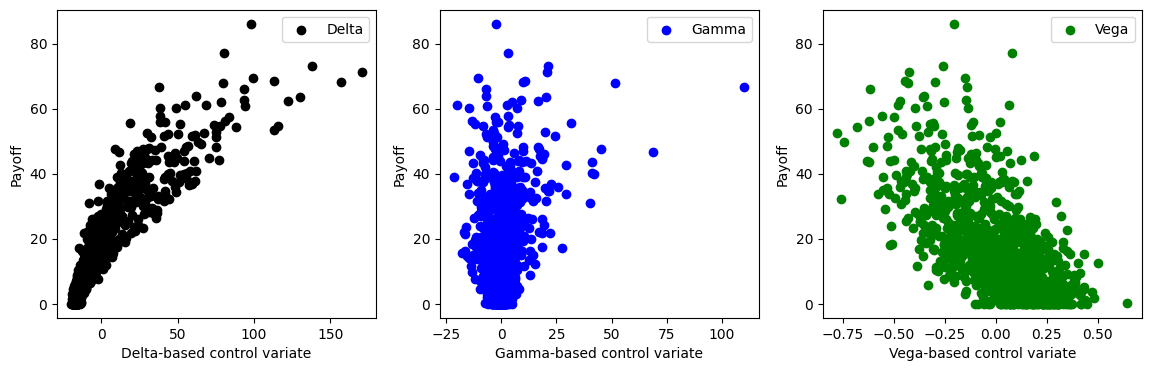

In [39]:
X = np.vstack([np.ones(M), cv1, cv2, cv3]).T

beta = np.linalg.lstsq(X, Y, rcond=None)[0]
print('Beta 0        : ',round(beta[0],3))
print('Beta 1 (delta): ',round(beta[1],3))
print('Beta 2 (gamma): ',round(beta[2],3))
print('Beta 3 (vega) : ',round(beta[3],3))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
naming = ['Delta','Gamma','Vega']
ax[0].scatter(cv1,Y,label=naming[0],color='k')
ax[1].scatter(cv2,Y,label=naming[1],color='b')
ax[2].scatter(cv3,Y,label=naming[2],color='g')
for i,a in enumerate(ax):
    a.set_ylabel('Payoff')
    a.set_xlabel(naming[i]+'-based control variate')
    a.legend()
plt.show()

In [40]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]
beta2 = -beta[2]
beta3 = -beta[3]

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# arrays for storing prices and variances
St = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St_max = np.full(shape=(M), fill_value=S0)

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

for j in range(1,N+1):

    # Compute hedge sensitivities
    call = fixed_strike_lookback_call(r, St[j-1], K, T-(j-1)*dt, St_max, np.sqrt(vt[j-1]), div)
    delta = call.delta_fd()
    gamma = call.gamma_fd()
    vega = call.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St[j] = St[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W[j-1,:] )

    # accumulate control variates
    cv1 += delta*(St[j] - St[j-1]*erddt)
    cv2 += gamma*((St[j] - St[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St[j-1]**2)
    cv3 += vega*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))

    mask = np.where(St[j] > St_max)
    St_max[mask] = St[j][mask]

# Compute Expectation and SE
CT = np.maximum(0, St_max - K) + beta1*cv1 + beta2*cv2 + beta3*cv3
C0_cv = np.exp(-r*T)*np.sum(CT)/M

SE_cv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) ) /np.sqrt(M)

time_comp_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,2),np.round(SE_cv,2)))
print("Calculation time: {0} sec".format(time_comp_cv))

Call value is $15.84 with SE +/- 0.18
Calculation time: 0.2373 sec


# Heston Model with antithetic and control (delta/gamma/vega) variates

In [41]:
# Start Timer
start_time = time.time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappadt = kappa*dt
sigmasdt = sigma*np.sqrt(dt)

# Control variate constant terms
erddt = np.exp((r-div)*dt)
egam1 = np.exp(2*(r-div)*dt)
egam2 = -2*erddt + 1
eveg1 = np.exp(-kappadt)
eveg2 = theta - theta*eveg1

# linear constants pre-determined for control variate weighting
beta1 = -beta[1]#-0.88
beta2 = -beta[2]#-0.43
beta3 = -beta[3]#-0.0003

# Generate Wiener variables
Z = np.random.normal(size=(N+1,M,2))
#W_ind = np.random.normal(size=(N_tot+1,M,1))
#W = Z @ lower_chol
W1 = rho_scalar*Z[:,:,0] + np.sqrt(1-rho_scalar**2)*Z[:,:,1]
W2 = rho_scalar*Z[:,:,0] - np.sqrt(1-rho_scalar**2)*Z[:,:,1]

# array for storing control variates
cv1 = np.full(shape=(M), fill_value=0.0)
cv2 = np.full(shape=(M), fill_value=0.0)
cv3 = np.full(shape=(M), fill_value=0.0)

# arrays for storing prices and variances
St1 = np.full(shape=(N+1,M), fill_value=S0)
St2 = np.full(shape=(N+1,M), fill_value=S0)
vt = np.full(shape=(N+1,M), fill_value=vt0)

# array for storing maximum's
St1_max = np.full(shape=(M), fill_value=S0)
St2_max = np.full(shape=(M), fill_value=S0)

for j in range(1,N+1):
    # Compute hedge sensitivities
    call1 = fixed_strike_lookback_call(r, St1[j-1], K, T-(j-1)*dt, St1_max, np.sqrt(vt[j-1]), div)
    call2 = fixed_strike_lookback_call(r, St2[j-1], K, T-(j-1)*dt, St2_max, np.sqrt(vt[j-1]), div)
    delta1 = call1.delta_fd()
    delta2 = call2.delta_fd()
    gamma1 = call1.gamma_fd()
    gamma2 = call2.gamma_fd()
    vega1 = call1.vega_fd()
    vega2 = call2.vega_fd()

    # Simulate variance processes
    vt[j] = vt[j-1] + kappadt*(theta - vt[j-1]) + sigmasdt*np.sqrt(vt[j-1])*Z[j-1,:,0]

    # Simulate log asset prices
    nudt = (r - div - 0.5*vt[j])*dt
    St1[j] = St1[j-1]*np.exp( nudt + np.sqrt(vt[j]*dt)*W1[j-1,:] )
    St2[j] = St2[j-1]*np.exp( nudt - np.sqrt(vt[j]*dt)*W2[j-1,:] )

    # accumulate control variates
    cv1 += delta1*(St1[j] - St1[j-1]*erddt) + delta2*(St2[j] - St2[j-1]*erddt)
    cv2 += gamma1*((St1[j] - St1[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St1[j-1]**2) \
         + gamma2*((St2[j] - St2[j-1])**2 - (egam1*np.exp(vt[j-1]*dt) + egam2)*St2[j-1]**2)
    cv3 += vega1*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1])) \
         + vega2*((vt[j] - vt[j-1]) - (vt[j-1]*eveg1+eveg2-vt[j-1]))

    mask1 = np.where(St1[j] > St1_max)
    mask2 = np.where(St2[j] > St2_max)
    St1_max[mask1] = St1[j][mask1]
    St2_max[mask2] = St2[j][mask2]

# Compute Expectation and SE
CT = 0.5*(np.maximum(0, St1_max - K) + np.maximum(0, St2_max - K) \
      + beta1*cv1 + beta2*cv2 + beta3*cv3)

C0_acv = np.exp(-r*T)*np.sum(CT)/M

SE_acv = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_acv)**2) / (M-1) ) /np.sqrt(M)

time_comp_acv = round(time.time() - start_time,4)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0_acv,2),np.round(SE_acv,2)))
print("Calculation time: {0} sec".format(time_comp_acv))

Call value is $15.88 with SE +/- 0.17
Calculation time: 0.4869 sec


# Compare computation time and variance reduction

In [45]:
C0_variates = [C0_fast, C0_av, C0_cv, C0_acv]
se_variates = [SE_fast, SE_av, SE_cv, SE_acv]
se_red = [round(SE_fast/se,2) for se in se_variates]
comp_time = [time_comp_fast, time_comp_av, time_comp_cv, time_comp_acv]
rel_time = [round(mc_time/time_comp_fast,2) for mc_time in comp_time]
data = {'Lookback Call Option Value': np.round(C0_variates,3),
        'Standard Error SE': np.round(se_variates,3),
        'SE Reduction Multiple': se_red,
        'Relative Computation Time': rel_time}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Fast Estimate', 'with antithetic variate',
'with control variates', 'with antithetic and control variates'])
df

,Lookback Call Option Value,Standard Error SE,SE Reduction Multiple,Relative Computation Time
Fast Estimate,16.689,0.461,1.00,1.00
with antithetic variate,15.164,0.312,1.48,1.43
with control variates,15.843,0.176,2.63,32.07
with antithetic and control variates,15.882,0.171,2.69,65.80


<Figure size 1000x500 with 0 Axes>

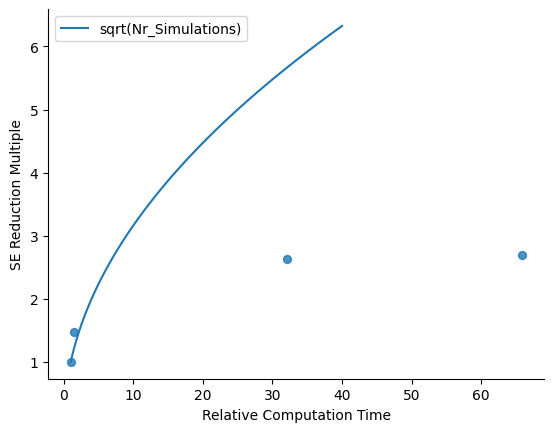

In [46]:
# @title SE Reduction Multiple vs Relative Computation Time

from matplotlib import pyplot as plt

x = np.linspace(1, 40, 100)
y = np.sqrt(x)

fig = plt.figure(figsize = (10, 5))

df.plot(kind='scatter', x='Relative Computation Time', y='SE Reduction Multiple', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.plot(x, y, label="sqrt(Nr_Simulations)")
plt.legend(loc="upper left")

Control variate too expensive to calculate/ too weakly correlated and thus not worth it since additional simulations (M) reduce the SE $\propto \frac{1}{\sqrt{M}}$